In [2]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_style("ticks")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [3]:
#path = '/Users/olivia.rourke/Desktop/Berkley/20240516_MEYDT011/plots-sup/4gRNA'
path = '/Volumes/Elements 1/Illumina/20240516_MEYDT011/plots-sup/'
files = glob.glob(f"{path}/*x4gRNAs*DF.csv")
#files = glob.glob('/Volumes/Elements 1/*.*')
CMAP = sns.color_palette("Spectral",12)

(0.8996539792387543, 0.340715109573241, 0.2848904267589389)


# How many gRNAs are mutated vs Theory Prediction 

In [8]:
def process_file(file):
    
    import pandas as pd
    import numpy as np
    import plotly
    import os
    from itertools import combinations
    
    try:
        df = pd.read_csv(file)
        ref = df.iloc[0]
        end = len(df.columns) - 4 #last 4 entries are ID
        values = ref.iloc[0:end].values
        ref_values = df.iloc[0, 1:end].values 
        matches = (df.iloc[:, 1:end].values == ref_values).all(axis=1)
        
        sequence_values = df.iloc[:, 1:end].values
        comparison_matrix = (sequence_values == ref_values).astype(int)

        condition1 = (ref_values[53:124] == 2) & (sequence_values[:, 53:124] == 3)
        condition2 = (ref_values[119:170] == 4) & (sequence_values[:, 119:170] == 1)

        comparison_matrix[:, 53:124][condition1] = 0
        comparison_matrix[:, 119:170][condition2] = 0
     
        grna_1 = comparison_matrix[:, 53:73]
        grna_2 = comparison_matrix[:, 104:124]
        grna_3 = comparison_matrix[:, 119:142]
        grna_4 = comparison_matrix[:, 149:170]
      
        num_reads = comparison_matrix.shape[0]
        new_matrix = np.zeros((num_reads, 4))

        for i in range(num_reads):
            if np.any(grna_1[i, :] == 0):
                new_matrix[i, 0] = 1
            if np.any(grna_2[i, :] == 0):
                new_matrix[i, 1] = 1
            if np.any(grna_3[i, :] == 0):
                new_matrix[i, 2] = 1
            if np.any(grna_4[i, :] == 0):
                new_matrix[i, 3] = 1

        grna_df = pd.DataFrame(new_matrix, columns=['grna_1', 'grna_2', 'grna_3', 'grna_4'])
        
        
        matrices = [grna_1, grna_2, grna_3, grna_4]
        matrix_names = ['grna_1', 'grna_2', 'grna_3', 'grna_4']

        names = []
        zeros = [] #mutations
        zeros_per_row = [] #mutations per read
        reads_no_mutations = []  #number of reads with no mutations
        percent_reads_with_mutations = []  #percentage of reads with mutations


        for name, matrix in zip(matrix_names, matrices):
            number_of_zeros = np.count_nonzero(matrix == 0) #finds how many mutations in each gRNA
            zeros_per_row_value = number_of_zeros / matrix.shape[0] #Average number of mutations per read

            rows_with_no_zeros = np.all(matrix != 0, axis=1) #find rows with no mutations in each gRNA matrix
            num_reads_no_mutations = np.sum(rows_with_no_zeros) 

            total_reads = matrix.shape[0] #total rows in gRNA
            num_reads_with_mutations = total_reads - num_reads_no_mutations 
            percent_with_mutations = (num_reads_with_mutations / total_reads) * 100

            names.append(name)
            zeros.append(number_of_zeros)
            zeros_per_row.append(zeros_per_row_value)
            reads_no_mutations.append(num_reads_no_mutations)
            percent_reads_with_mutations.append(percent_with_mutations)


        # Total across all gRNA's
        total_zeros = sum(zeros)
        total_rows = sum(matrix.shape[0] for matrix in matrices)
        total_zeros_per_row = total_zeros / total_rows
        total_reads_no_mutations = sum(reads_no_mutations)
        total_reads_with_mutations = total_rows - total_reads_no_mutations
        total_percent_with_mutations = (total_reads_with_mutations / total_rows) * 100


        names.append('total')
        zeros.append(total_zeros)
        zeros_per_row.append(total_zeros_per_row)
        reads_no_mutations.append(total_reads_no_mutations)
        percent_reads_with_mutations.append(total_percent_with_mutations)

        # Create DataFrame
        total_mut = pd.DataFrame({
            'gRNA': names,
            'Number of mutations': zeros, #how many total mutations in each gRNA
            'Average Number of mutations per read': zeros_per_row, #how many mutations per read
            'Number of reads with no mutations': reads_no_mutations, #how many reads match reference sequence
            'Percent of reads with mutations': percent_reads_with_mutations #how many reads in gRNA are mutated
        })

        
        grna_sums = grna_df.sum(axis=1)
        percentages = grna_sums.value_counts(normalize=True) * 100
        prob = percentages.sort_index() / 100

        # Create the bar plot for the histogram
        fig = plt.figure(figsize=(4, 4))
        ax = plt.gca()
        plt.bar(prob.index, prob.values, width=0.5, linewidth = 0, color='blue', alpha=0.7, label='experimental data')

        # Define p and q for the line plot
        p = np.array(percent_reads_with_mutations[:-1]) / 100
        q = 1 - p

        # Function to calculate probability of exactly k mutations
        def calculate_probability_of_k_mutations(p, q, k):
            n = len(p)
            total_prob = 0
            for comb in combinations(range(n), k):
                prob = 1
                for i in range(n):
                    if i in comb:
                        prob *= p[i]
                    else:
                        prob *= q[i]
                total_prob += prob
            return total_prob

        # Calculate probabilities for exactly 0 to 4 mutations
        probabilities = {}
        for k in range(5):
            prob_k_mutations = calculate_probability_of_k_mutations(p, q, k)
            probabilities[k] = prob_k_mutations

        # Create the line plot for the probabilities
        plt.plot(list(probabilities.keys()), list(probabilities.values()), marker='o', color='darkgrey', label='expected if mutations are uncorrelated')

        # Customize the plot
        plt.xlabel('Number of Mutated gRNAs')
        plt.ylabel('Proportion of reads')
        plt.title('Probability of mutating multiple gRNAs')
        plt.figtext(0.5, -0.01, f'File: {os.path.basename(file)}', ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
        plt.xticks(np.arange(0, 5, 1))
        #plt.grid(axis='y')
        plt.ylim(0,1)
        plt.legend()
        plt.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show the plot
        plt.show()
        plt.tight_layout()
        fig.savefig(file+"AcrossgRNACorr.pdf")
        
        print(total_mut)

    except Exception as e:
        print(f'Error processing {file}: {e}')
        

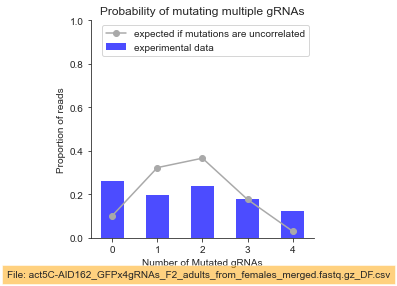

     gRNA  Number of mutations  Average Number of mutations per read  \
0  grna_1                34904                              1.023068   
1  grna_2                48488                              1.421227   
2  grna_3                65074                              1.907378   
3  grna_4                48081                              1.409297   
4   total               196547                              1.440242   

   Number of reads with no mutations  Percent of reads with mutations  
0                              22413                        34.305478  
1                              15328                        55.072251  
2                              22238                        34.818419  
3                              18115                        46.903303  
4                              78094                        42.774863  


<Figure size 432x288 with 0 Axes>

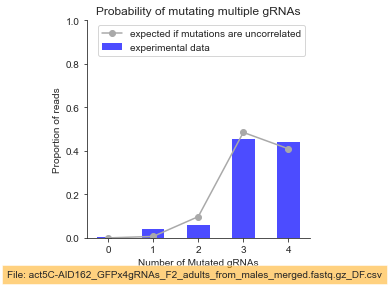

     gRNA  Number of mutations  Average Number of mutations per read  \
0  grna_1                27276                              1.400996   
1  grna_2                39842                              2.046433   
2  grna_3                97169                              4.990960   
3  grna_4                54813                              2.815399   
4   total               219100                              2.813447   

   Number of reads with no mutations  Percent of reads with mutations  
0                               9494                        51.235297  
1                               1293                        93.358673  
2                               1921                        90.133032  
3                                964                        95.048539  
4                              13672                        82.443885  


<Figure size 432x288 with 0 Axes>

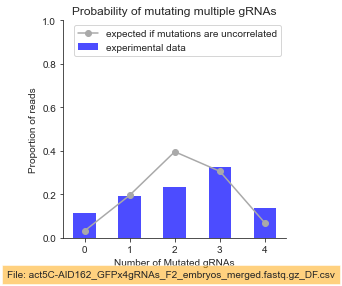

     gRNA  Number of mutations  Average Number of mutations per read  \
0  grna_1                22829                              0.811727   
1  grna_2                47451                              1.687207   
2  grna_3                81939                              2.913490   
3  grna_4                51488                              1.830750   
4   total               203707                              1.810793   

   Number of reads with no mutations  Percent of reads with mutations  
0                              20508                        27.080074  
1                               7473                        73.428389  
2                              12790                        54.522827  
3                              10346                        63.212914  
4                              51117                        54.561051  


<Figure size 432x288 with 0 Axes>

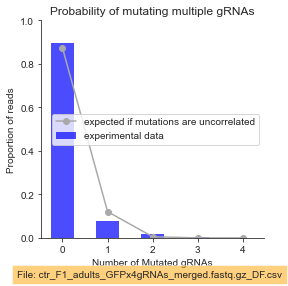

     gRNA  Number of mutations  Average Number of mutations per read  \
0  grna_1                  636                              0.022302   
1  grna_2                 1031                              0.036153   
2  grna_3                 1212                              0.042499   
3  grna_4                 2283                              0.080055   
4   total                 5162                              0.045252   

   Number of reads with no mutations  Percent of reads with mutations  
0                              28075                         1.553405  
1                              27711                         2.829792  
2                              27987                         1.861982  
3                              26543                         6.925451  
4                             110316                         3.292657  


<Figure size 432x288 with 0 Axes>

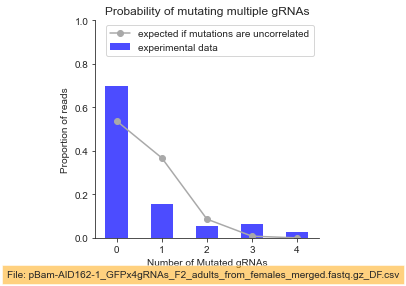

     gRNA  Number of mutations  Average Number of mutations per read  \
0  grna_1                   11                              0.144737   
1  grna_2                   26                              0.342105   
2  grna_3                   40                              0.526316   
3  grna_4                   44                              0.578947   
4   total                  121                              0.398026   

   Number of reads with no mutations  Percent of reads with mutations  
0                                 72                         5.263158  
1                                 63                        17.105263  
2                                 67                        11.842105  
3                                 59                        22.368421  
4                                261                        14.144737  


<Figure size 432x288 with 0 Axes>

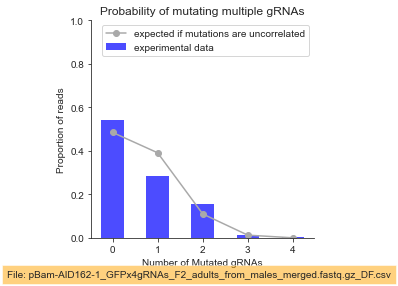

     gRNA  Number of mutations  Average Number of mutations per read  \
0  grna_1                 2279                              0.229668   
1  grna_2                 2702                              0.272297   
2  grna_3                 8988                              0.905774   
3  grna_4                 7094                              0.714905   
4   total                21063                              0.530661   

   Number of reads with no mutations  Percent of reads with mutations  
0                               9123                         8.062078  
1                               8547                        13.866774  
2                               8157                        17.797037  
3                               7396                        25.466089  
4                              33223                        16.297995  


<Figure size 432x288 with 0 Axes>

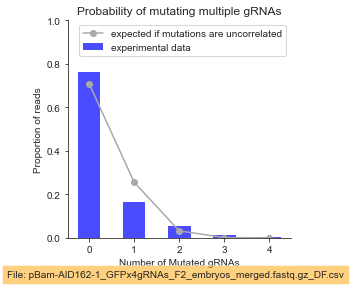

     gRNA  Number of mutations  Average Number of mutations per read  \
0  grna_1                 2620                              0.106348   
1  grna_2                 5200                              0.211073   
2  grna_3                 7162                              0.290713   
3  grna_4                 6408                              0.260107   
4   total                21390                              0.217060   

   Number of reads with no mutations  Percent of reads with mutations  
0                              23640                         4.042864  
1                              22210                         9.847378  
2                              23115                         6.173892  
3                              21551                        12.522325  
4                              90516                         8.146615  


<Figure size 432x288 with 0 Axes>

In [9]:
for file in files:
    process_file(file)

# Probability of Mutation at Each Mutable Base

In [6]:
def plot_mutation_probabilities(file):
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    df = pd.read_csv(file)
    ref = df.iloc[0]
    end = len(df.columns) - 4 #last 4 entries are ID
    values = ref.iloc[0:end].values
    
    ref_values = df.iloc[0, 1:end].values 
    sequence = df.iloc[:, 1:end].values
    
    grna_slices = [
    (53, 73),
    (104, 124),
    (119, 142),
    (149, 170)]
    
    slice_colors = ['grey', 'lightblue', 'lightgreen', 'lightgoldenrodyellow']
    slice_colors = [(0.7,0.7,0.7), (0.7,0.7,0.7), (0.7,0.7,0.7),(0.7,0.7,0.7)]

    
    # Combine mutable positions for both C to T and G to A mutations within specific gRNA slices
    mutable_positions = []
    mutation_types = []
    
    for i, (start, end) in enumerate(grna_slices):
        for pos in range(start, end):
            if (i < 2 and ref_values[pos] == 2):  # Cs in gRNA slices 1 and 2
                mutable_positions.append(pos)
                mutation_types.append('C to T')
            elif (i >= 2 and ref_values[pos] == 4):  # Gs in gRNA slices 3 and 4
                mutable_positions.append(pos)
                mutation_types.append('G to A')

    # print(f"Number of mutable bases: {len(mutable_positions)}")  # Should be 35

    # Initialize mutation counts
    c_counts = np.zeros(sequence.shape[1])
    g_counts = np.zeros(sequence.shape[1])
    c_to_t_counts = np.zeros(sequence.shape[1])
    g_to_a_counts = np.zeros(sequence.shape[1])

    # Loop through each read and each position to count mutations
    for read in range(sequence.shape[0]): # goes through reads
        for pos in range(sequence.shape[1]): # goes through position/base

            if ref_values[pos] == 2:
                c_counts[pos] += 1
                if sequence[read, pos] == 3:
                    c_to_t_counts[pos] += 1

            if ref_values[pos] == 4:
                g_counts[pos] += 1
                if sequence[read, pos] == 1:
                    g_to_a_counts[pos] += 1

    # Calculate probabilities
    c_to_t_probs = np.divide(c_to_t_counts, c_counts, out=np.zeros_like(c_to_t_counts, dtype=float), where=c_counts != 0)
    g_to_a_probs = np.divide(g_to_a_counts, g_counts, out=np.zeros_like(g_to_a_counts, dtype=float), where=g_counts != 0)

    # Plot combined histogram with C to T and G to A transitions highlighted
    def plot_combined_histogram(data_c_to_t, data_g_to_a, positions, mutation_types, title, xlabel, ylabel):
        fig = plt.figure(figsize=(8, 3))
        ax = plt.gca()
        c_to_t_added = False
        g_to_a_added = False
        
        # Add shaded regions for each gRNA slice with different colors
        for i, (start, end) in enumerate(grna_slices):
            try:
                start_index = next(i for i, v in enumerate(positions) if v >= start)
                end_index = next(i for i, v in enumerate(positions) if v >= min(end, max(positions)))
                # print(f"Shading gRNA slice {i+1}: start_index={start_index}, end_index={end_index}")
                ax.axvspan(start_index, end_index, color=slice_colors[i], alpha=0.2)
            except StopIteration:
                # Skip if start or end position is not found in mutable_positions
                # print(f"gRNA slice {i+1} not found in mutable positions")
                continue

        for idx, (pos, mut_type) in enumerate(zip(positions, mutation_types)):
            if mut_type == 'C to T':
                plt.bar(idx, data_c_to_t[pos]*100, alpha=1, edgecolor='none', color=CMAP[4], label='C-T' if not c_to_t_added else "")
                c_to_t_added = True
            elif mut_type == 'G to A':
                plt.bar(idx, data_g_to_a[pos]*100, alpha=1, edgecolor='none', color=CMAP[9], label='G-A' if not g_to_a_added else "")
                g_to_a_added = True

        plt.title(title)
        plt.figtext(0.5, -0.01, f'File: {os.path.basename(file)}', ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.ylim(0, 100)  # Set y-axis limit from 0 to 1
        plt.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add index labels for each mutable base
        plt.xticks(range(len(positions)), [str(idx + 1) for idx in range(len(positions))])
        plt.legend()
        plt.show()
        #plt.tight_layout()
        fig.savefig(file+"_MutableBasesEach.pdf")

    # Plot combined probabilities with mutable base indices
    plot_combined_histogram(c_to_t_probs, g_to_a_probs, mutable_positions, mutation_types, 'Probability of C to T and G to A Transitions', 'Mutable Base Index', '% mismatch')


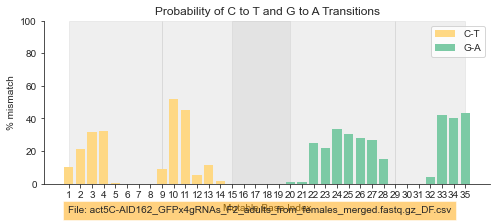

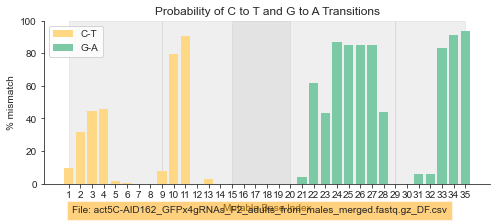

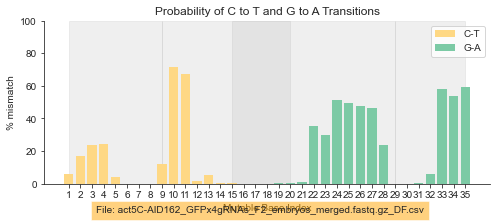

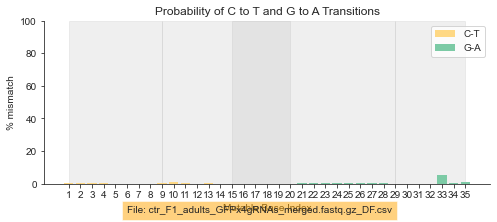

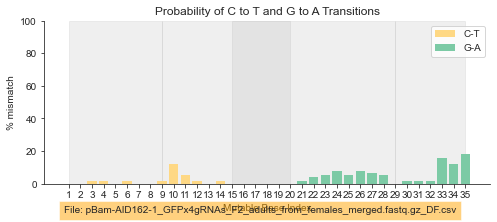

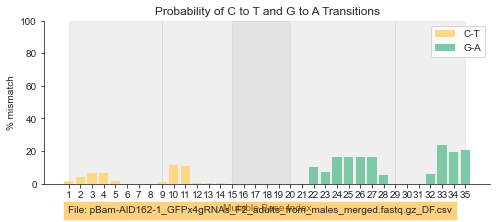

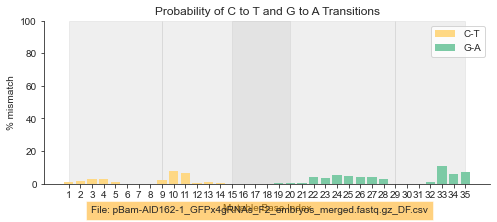

In [7]:
for file in files:
    plot_mutation_probabilities(file)

# Number of Mutations in each Mutable Basis (loop through reads)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_mutation_probabilities(file):
    df = pd.read_csv(file)
    ref = df.iloc[0]
    end = len(df.columns) - 4 # last 4 entries are ID
    ref_values = ref.iloc[1:end].values 
    sequence = df.iloc[:, 1:end].values

    grna_slices = [
        (53, 73),
        (104, 124),
        (119, 142),
        (149, 170)
    ]
    
    mutable_positions = []
    mutation_types = []

    for i, (start, end) in enumerate(grna_slices):
        for pos in range(start, end):
            if (i < 2 and ref_values[pos] == 2):  # Cs in gRNA slices 1 and 2
                mutable_positions.append(pos)
                mutation_types.append('C to T')
            elif (i >= 2 and ref_values[pos] == 4):  # Gs in gRNA slices 3 and 4
                mutable_positions.append(pos)
                mutation_types.append('G to A')

    print(f"Number of mutable bases: {len(mutable_positions)}")  # Should be 35

    mutation_counts_per_read = []

    # only counts mutations of type C to T or G to A in mutable positions 
    for read in sequence:
        mutation_count = 0
        for i, pos in enumerate(mutable_positions):
            if (mutation_types[i] == 'C to T' and read[pos] == 3) or (mutation_types[i] == 'G to A' and read[pos] == 1):
                mutation_count += 1
        mutation_counts_per_read.append(mutation_count)

    plt.figure(figsize=(10, 6))
    plt.hist(mutation_counts_per_read, bins=range(37), color='blue', alpha=0.7, edgecolor='black', align='left')
    plt.xlabel('Number of Mutated Bases per Read')
    plt.ylabel('Count of Reads')
    plt.figtext(0.5, -0.01, f'File: {os.path.basename(file)}', ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.title('Histogram of Number of Mutated Bases per Read')
    plt.xticks(range(0, 36))
    plt.tight_layout()
    plt.show()
    
# Note: should change y axis from raw reads to percent of reads

Number of mutable bases: 35


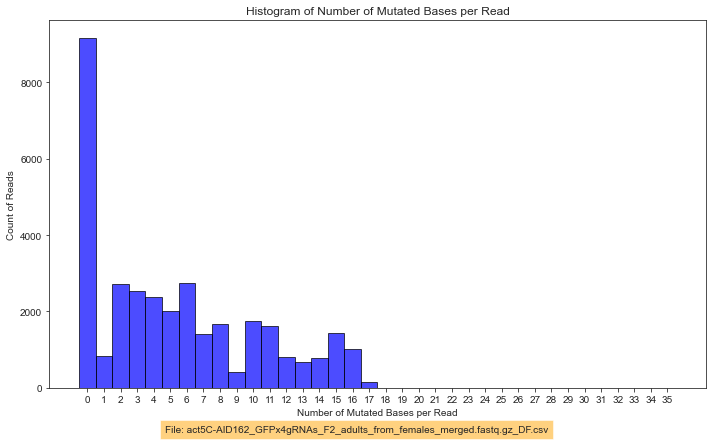

Number of mutable bases: 35


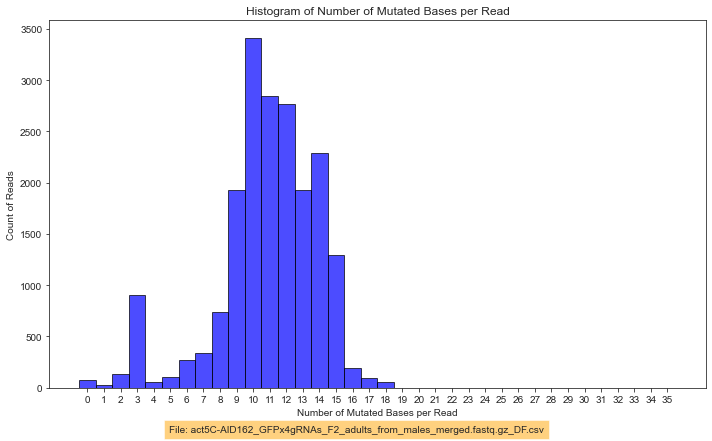

Number of mutable bases: 35


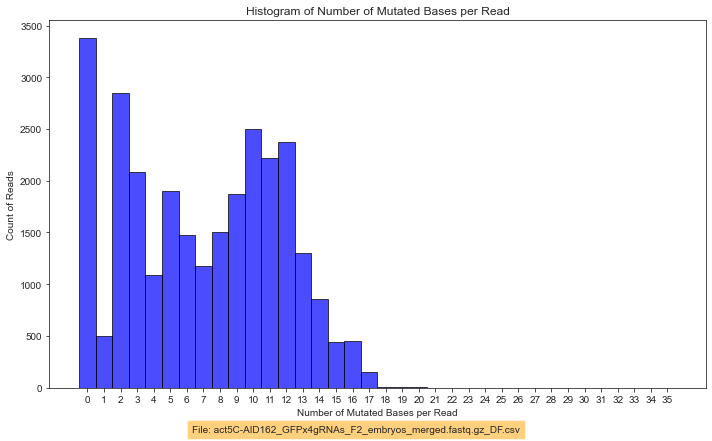

Number of mutable bases: 35


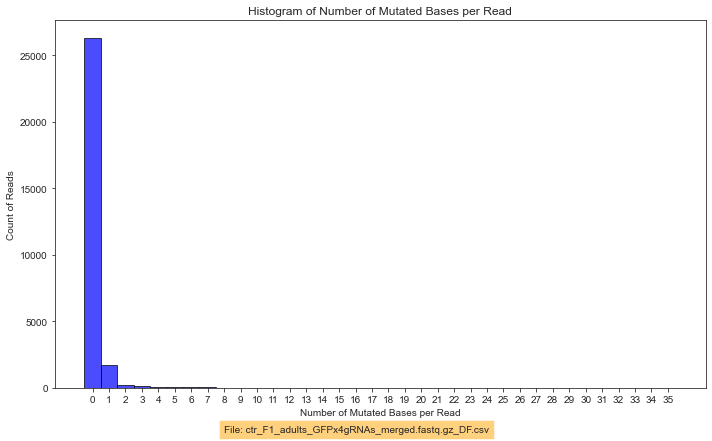

Number of mutable bases: 35


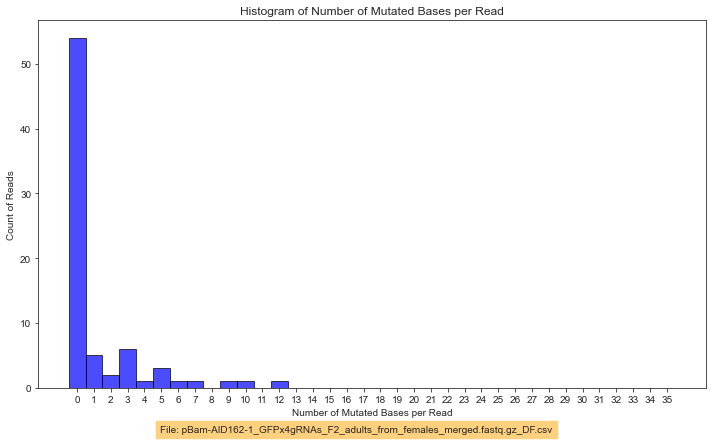

Number of mutable bases: 35


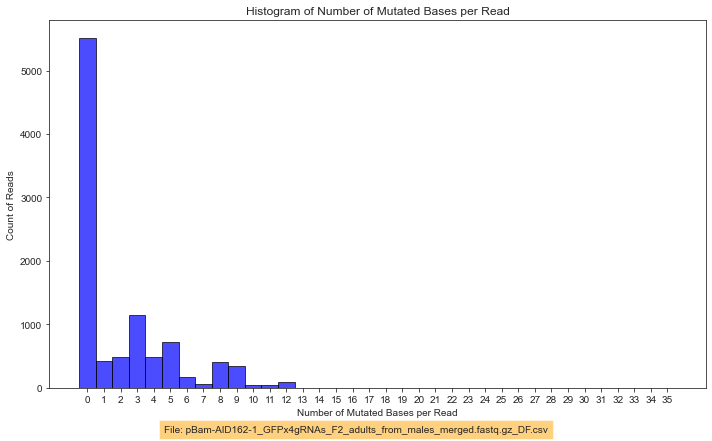

Number of mutable bases: 35


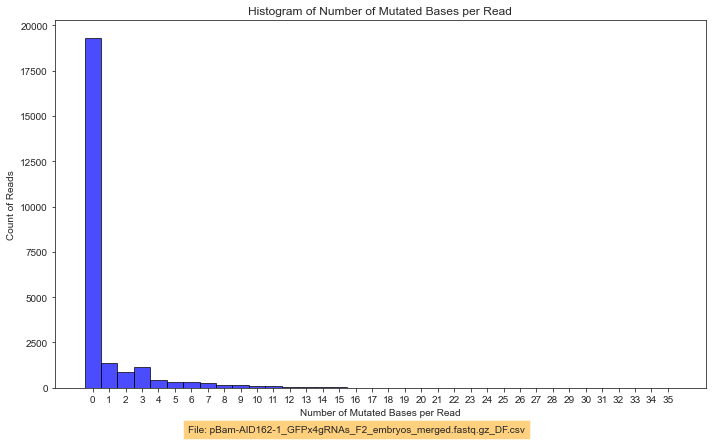

In [11]:
for file in files:
    plot_mutation_probabilities(file)